In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

##导入文件：
因为colab上传的文件在每一次重新连接之后都会被情况，因此这里采用了从google drive 上导入文件的方法。使用了python的PyDrive包以及google对应的SDK 使得colab笔记本可以使用储存在google drive上的文件；第一次运行GoogleAuth的时候会鉴权

In [0]:
# 安装 PyDrive 操作库，该操作每个 notebook 只需要执行一次
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 授权登录，仅第一次的时候会鉴权
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
file_list = drive.ListFile({'q': "'14iqs6BpxiqB26N9mGDs8qNzbCTv_ZuYG' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s, mimeType: %s' % (file1['title'], file1['id'], file1["mimeType"]))

title: iBeacon_RSSI_Unlabeled.csv, id: 1Z7rdDqAznTSrteZqIRgRdXBW_0wdZirR, mimeType: text/csv
title: iBeacon_RSSI_Labeled.csv, id: 12dS36HvL9ZvrNb2nxKNKlSiiFf-6ZgdT, mimeType: text/csv
title: iBeacon_Layout.jpg, id: 1bA7A5kMF5URXA8kLPle-zIEzMARZn-Wg, mimeType: image/jpeg


##导入数据
使用google drive之后可以获取每个文件的id（此处略过），通过该id可以把对应文件缓存到笔记本的当前目录下进行使用。之后可以使用pandas库读取csv文件，保存成为dataframe的格式，这里分别读取label和unlabel的数据

In [0]:
file = drive.CreateFile({'id': "1Z7rdDqAznTSrteZqIRgRdXBW_0wdZirR"}) 
file.GetContentFile('iBeacon_RSSI_Unlabeled.csv', "text/csv") 
file = drive.CreateFile({'id': "12dS36HvL9ZvrNb2nxKNKlSiiFf-6ZgdT"}) 
file.GetContentFile('iBeacon_RSSI_Labeled.csv', "text/csv")
unlabel=pd.read_csv('iBeacon_RSSI_Unlabeled.csv',sep=',',skiprows=0)
label=pd.read_csv('iBeacon_RSSI_Labeled.csv',sep=',',skiprows=0)

##特征工程
先对有标签的数据进行处理。由于位置信息被划分为200余个区域，而测试数据仅1000余个，如果直接进行分类很难取得很好的效果。因此这里采取了将x、y坐标分离的办法。将位置信息的x、y坐标分别拆分成两个特征；同时，将蓝牙传感器按x、y的位置分类。取同一坐标下蓝牙传感器强度的最大值作为该坐标上的信号强度值。

In [0]:
label['bx1']=[max(i[2],i[10]) for i in label.values]
label['bx2']=[max(i[3],i[6],i[9],i[11]) for i in label.values]
label['bx3']=[max(i[4],i[7],i[12]) for i in label.values]
label['bx4']=[max(i[5],i[8],i[13]) for i in label.values]
label['bx5']=[(i[10]) for i in label.values]
label['by1']=[max(i[3],i[4],i[5]) for i in label.values]
label['by2']=[max(i[6],i[7],i[8]) for i in label.values]
label['by3']=[max(i[2],i[9]) for i in label.values]
label['by4']=[max(i[10],i[11],i[12],i[13],i[14]) for i in label.values]

##数据集划分
首先选取了原dataframe中对应的列分别作为数据和标签；然后调用sklearn中的train_test_split函数划分测试集。这里采用了30%的数据作为测试集，同时，为了保证结果的可复现性，固定选取了0作为随机因子

In [0]:
xx_train,xx_test,xy_train,xy_test = train_test_split(label[['bx1','bx2','bx3','bx4','bx5']],label['x'],test_size=0.3,random_state=0)
yx_train,yx_test,yy_train,yy_test = train_test_split(label[['by1','by2','by3','by4']],label['y'],test_size=0.3,random_state=0)

##模型训练及预测
采用不同的模型对数据集进行分类，这里采用了：

1.   KNeighbors k近邻分类算法
2.   SVM 支持向量机分类算法



In [0]:
xknn = KNeighborsClassifier()
yknn = KNeighborsClassifier()
xsvc = SVC()
ysvc=SVC()
treex=DecisionTreeClassifier()
treey=DecisionTreeClassifier()
rfx =RandomForestClassifier()
rfy = RandomForestClassifier()

In [0]:
def classify(clfx,clfy):
  clfx.fit(xx_train,xy_train)
  xy=clfx.predict(xx_test)
  clfy.fit(yx_train,yy_train)
  yy=clfy.predict(yx_test) 
  return xy,yy

In [0]:
xy_predict,yy_predict=classify(rfx,rfy)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


##模型检验
采用预测位置和实际位置的Manhattan距离度量衡量模型的准确度；


---


取L2范数衡量总体误差

In [0]:
md = np.abs((np.array(list(map(ord,xy_test.values)))-np.array(list(map(ord,xy_predict)))))+np.abs(np.array(yy_test).astype(int)-np.array(yy_predict).astype(int))
l2 = np.sqrt(np.sum(np.square(md)))/len(xy_test)
print('曼哈顿距离的L2范数：')
print(l2)

曼哈顿距离的L2范数：
0.1582027271877394




---

#无标签数据
##特征工程
由于处理聚类问题，因此直接将13个蓝牙传感器的值作为特征输入
##模型训练
采用了以下的算法构建聚类模型：


1.   Kmeans算法
2.   层次聚类
3.   高斯混合模型
4.   密度聚类




In [0]:
b = unlabel.iloc[:,2:]
kmeans = KMeans(n_clusters=3)
agg = AgglomerativeClustering(n_clusters=3)
db = DBSCAN()
gmm =GaussianMixture(n_components=3)

##模型检验

##可视化
###t-sne
采用t-sne的方法将数据降维，使得原来的十三维的特征可以在二维的平面上表示
但是运算慢且效果不好
###PCA
最终采用PCA的方法进行降维


In [0]:
def cluster(method):
  result = method.fit_predict(b)
  #tsne=TSNE()
 # tsne.fit_transform(b)
  #bt = pd.DataFrame(tsne.embedding_,index=b.index)
  pca = PCA(n_components=2)
  bt=pd.DataFrame(pca.fit_transform(b))
  for i in range(3):
    d=bt[result==i]
    plt.scatter(d[0],d[1])

##作图
用matplotlib中的scatter函数绘制散点图

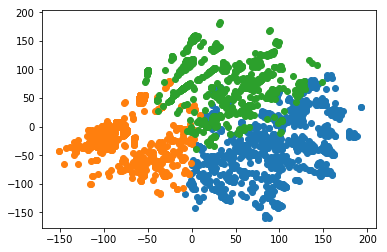

In [0]:
cluster(kmeans)


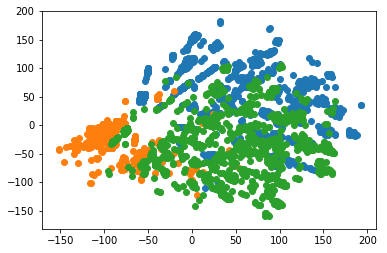

In [0]:
cluster(agg)

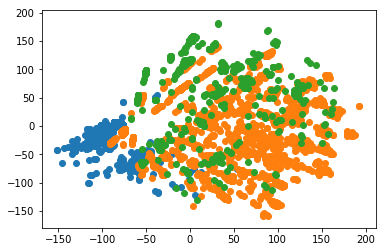

In [0]:
cluster(gmm)

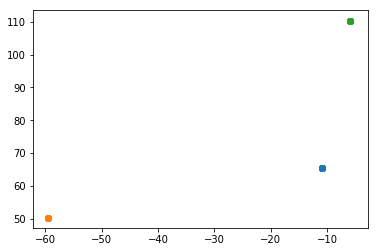

In [0]:
cluster(db)